# Load Data

In [15]:
import pandas as pd

BASE_PATH = 'Downloads/MNIST'
df = pd.read_csv(f'{BASE_PATH}/train.csv')
dff = df[:3000]
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
# Split dataset
train_df, valid_df = dff[:int(len(dff) * 0.8)], dff[int(len(dff) * 0.8):] 

In [16]:
print(f'Data Amount (Train, Valid): {len(train_df), len(valid_df)}')

Data Amount (Train, Valid): (2400, 600)


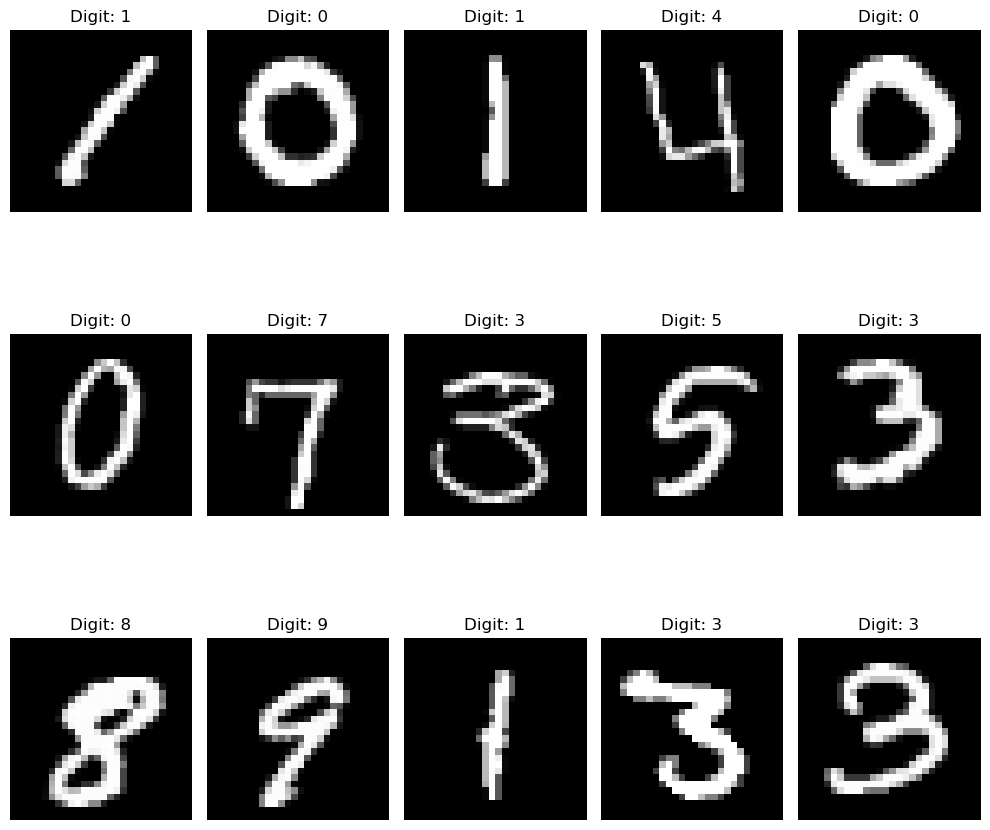

In [17]:
# Look at our data
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    data = train_df.iloc[i].values
    label, img = data[0], data[1:].reshape((28,28))
    ax.imshow(train_df.iloc[i].values[1:].reshape((28,28)), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Digit: {label}')  
    
plt.tight_layout()
plt.show()

In [19]:
train_df.to_csv('Downloads/dd.csv', index=False)

In [18]:
train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2396,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2397,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2398,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# EDA

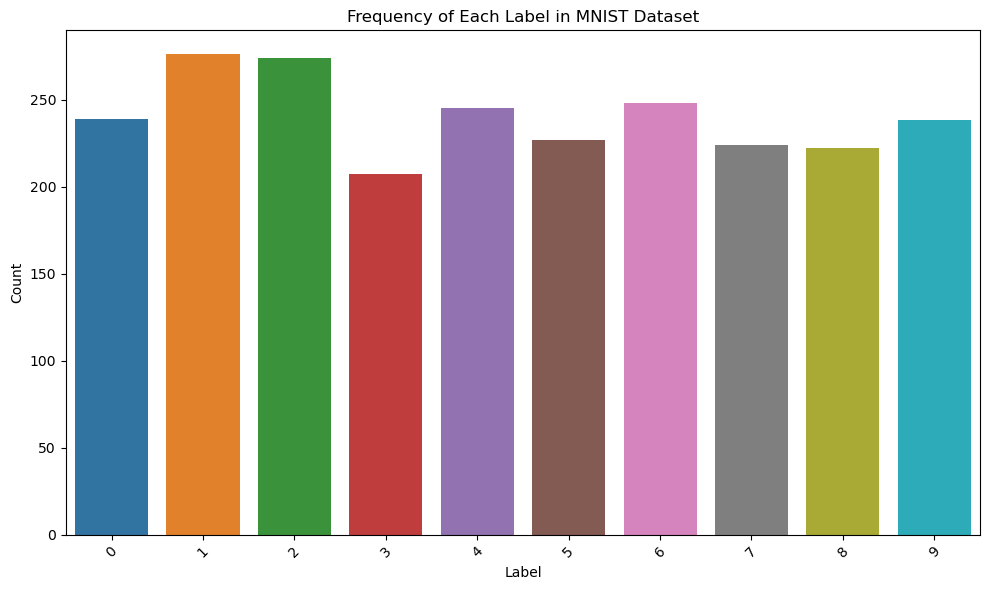

In [20]:
import seaborn as sns

label_counts = train_df['label'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Frequency of Each Label in MNIST Dataset')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


# Preprocessing

In [21]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torch

class MNISTDataset(Dataset):
    def __init__(self, data, transform=None, test=False):
        self.data = data
        self.test = test
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sample = self.data.iloc[index].values
        if self.test:
            label, img = 0, sample.reshape((28,28))
        else:
            label, img = sample[0], sample[1:].reshape((28,28))
        img = Image.fromarray(img.astype(np.uint8))
        
        if self.transform:
            img = self.transform(img)
        return img, label
    

# Data Augmentation

In [22]:
import torchvision
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.RandomRotation(10),  
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [23]:
batch_size = 64
train_dataset = MNISTDataset(train_df, transform=train_transform)
valid_dataset = MNISTDataset(valid_df, valid_transform)
test_dataset = MNISTDataset(test_df, valid_transform, test=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# CNN Model

In [83]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 28, 3, 1, 1)  
        self.conv2 = nn.Conv2d(28, 64, 3, 1, 1) 
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.25)
  
        self.fc1 = nn.Linear(12544, 64) 
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.dropout3(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)

Net(
  (conv1): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(28, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=12544, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

# Optimizer and Loss Function

In [84]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Metrics

In [85]:
from sklearn.metrics import accuracy_score

def calculate_accuracy(predictions, labels):
    predicted_labels = torch.argmax(predictions, dim=1)
    return accuracy_score(labels.cpu(), predicted_labels.cpu())

# Training

In [86]:
from tqdm.notebook import tqdm
import time

epochs = 40
start_time = time.time()

# Train and validate
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(tqdm(train_dataloader, desc=f'Epoch {epoch + 1} Training')):
        data, target = data.float().to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    train_loss /= len(train_dataloader)
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_predictions = []
    val_labels = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(valid_dataloader, desc=f'Epoch {epoch + 1} Validation')):
            data, target = data.float().to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            val_loss += loss.item()
            val_predictions.extend(torch.softmax(output, dim=1).cpu().tolist())  # Softmax without logits
            val_labels.extend(target.tolist())
    
    val_loss /= len(valid_dataloader)
    
    # Calculate validation accuracy
    val_accuracy = calculate_accuracy(torch.tensor(val_predictions), torch.tensor(val_labels))
    
    print(f"Epoch {epoch+1}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
    
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

Epoch 1 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Training Loss: 2.1712611066667655, Validation Loss: 1.4426371097564696, Validation Accuracy: 0.62


Epoch 2 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2, Training Loss: 1.6583381922621476, Validation Loss: 0.7769330739974976, Validation Accuracy: 0.7666666666666667


Epoch 3 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3, Training Loss: 1.2539088710358268, Validation Loss: 0.4303846463561058, Validation Accuracy: 0.89


Epoch 4 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4, Training Loss: 1.0384764247818996, Validation Loss: 0.31060249656438826, Validation Accuracy: 0.9333333333333333


Epoch 5 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5, Training Loss: 0.8924822948480907, Validation Loss: 0.2683175057172775, Validation Accuracy: 0.9483333333333334


Epoch 6 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 6 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6, Training Loss: 0.8542589294283014, Validation Loss: 0.23337947055697442, Validation Accuracy: 0.9433333333333334


Epoch 7 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 7 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7, Training Loss: 0.7526284142544395, Validation Loss: 0.1881484270095825, Validation Accuracy: 0.965


Epoch 8 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 8 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8, Training Loss: 0.730941819517236, Validation Loss: 0.1666234128177166, Validation Accuracy: 0.955


Epoch 9 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 9 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9, Training Loss: 0.685900470928142, Validation Loss: 0.1431792587041855, Validation Accuracy: 0.96


Epoch 10 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 10 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10, Training Loss: 0.6541300423835453, Validation Loss: 0.14436108358204364, Validation Accuracy: 0.9666666666666667


Epoch 11 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 11 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11, Training Loss: 0.600970690187655, Validation Loss: 0.14756052643060685, Validation Accuracy: 0.9566666666666667


Epoch 12 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 12 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12, Training Loss: 0.6150634641710081, Validation Loss: 0.1359847415238619, Validation Accuracy: 0.955


Epoch 13 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 13 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13, Training Loss: 0.6181308274206362, Validation Loss: 0.1422974534332752, Validation Accuracy: 0.9616666666666667


Epoch 14 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 14 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14, Training Loss: 0.584008611346546, Validation Loss: 0.11244633290916681, Validation Accuracy: 0.9683333333333334


Epoch 15 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 15 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15, Training Loss: 0.5743490724187148, Validation Loss: 0.1101129624992609, Validation Accuracy: 0.9666666666666667


Epoch 16 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 16 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 16, Training Loss: 0.5629427582025528, Validation Loss: 0.10397063698619605, Validation Accuracy: 0.9666666666666667


Epoch 17 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 17 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 17, Training Loss: 0.5616369643493703, Validation Loss: 0.1166914414614439, Validation Accuracy: 0.9633333333333334


Epoch 18 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 18 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 18, Training Loss: 0.5426589587801381, Validation Loss: 0.11568088755011559, Validation Accuracy: 0.9716666666666667


Epoch 19 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 19 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 19, Training Loss: 0.5082521069990961, Validation Loss: 0.10757095254957676, Validation Accuracy: 0.97


Epoch 20 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 20 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 20, Training Loss: 0.499920716411189, Validation Loss: 0.10154750980436802, Validation Accuracy: 0.975


Epoch 21 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 21 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 21, Training Loss: 0.4956457379617189, Validation Loss: 0.09892317317426205, Validation Accuracy: 0.97


Epoch 22 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 22 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 22, Training Loss: 0.513241495741041, Validation Loss: 0.0860036090016365, Validation Accuracy: 0.975


Epoch 23 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 23 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 23, Training Loss: 0.4808612379588579, Validation Loss: 0.11370085496455432, Validation Accuracy: 0.9683333333333334


Epoch 24 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 24 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 24, Training Loss: 0.4672735255015524, Validation Loss: 0.09370867181569338, Validation Accuracy: 0.9766666666666667


Epoch 25 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 25 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 25, Training Loss: 0.4779985288256093, Validation Loss: 0.09186135530471802, Validation Accuracy: 0.9733333333333334


Epoch 26 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 26 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 26, Training Loss: 0.45157832926825475, Validation Loss: 0.12156865373253822, Validation Accuracy: 0.97


Epoch 27 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 27 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 27, Training Loss: 0.4313152291272816, Validation Loss: 0.13263459466397762, Validation Accuracy: 0.965


Epoch 28 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 28 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 28, Training Loss: 0.4496702716538781, Validation Loss: 0.10412060264497995, Validation Accuracy: 0.9716666666666667


Epoch 29 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 29 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 29, Training Loss: 0.43473538442661885, Validation Loss: 0.11661007315851749, Validation Accuracy: 0.9683333333333334


Epoch 30 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 30 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 30, Training Loss: 0.43279933105958135, Validation Loss: 0.0970410043373704, Validation Accuracy: 0.9733333333333334


Epoch 31 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 31 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 31, Training Loss: 0.42561371036266027, Validation Loss: 0.10157866412773728, Validation Accuracy: 0.97


Epoch 32 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 32 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 32, Training Loss: 0.46163794633589295, Validation Loss: 0.09210601001977921, Validation Accuracy: 0.975


Epoch 33 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 33 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 33, Training Loss: 0.43969768717100743, Validation Loss: 0.08947701985016465, Validation Accuracy: 0.9733333333333334


Epoch 34 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 34 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 34, Training Loss: 0.4173009395599365, Validation Loss: 0.09061126743908972, Validation Accuracy: 0.97


Epoch 35 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 35 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 35, Training Loss: 0.410273000205818, Validation Loss: 0.11143130008131266, Validation Accuracy: 0.9683333333333334


Epoch 36 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 36 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 36, Training Loss: 0.4086455679253528, Validation Loss: 0.08636094611138105, Validation Accuracy: 0.9733333333333334


Epoch 37 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 37 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 37, Training Loss: 0.4261389864902747, Validation Loss: 0.10242740344256163, Validation Accuracy: 0.965


Epoch 38 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 38 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 38, Training Loss: 0.39404039673115077, Validation Loss: 0.11834656093269587, Validation Accuracy: 0.9666666666666667


Epoch 39 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 39 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 39, Training Loss: 0.3879977774463202, Validation Loss: 0.11124699637293815, Validation Accuracy: 0.965


Epoch 40 Training:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch 40 Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 40, Training Loss: 0.38984651942002146, Validation Loss: 0.10310804070904851, Validation Accuracy: 0.9716666666666667


# Analyzing our results

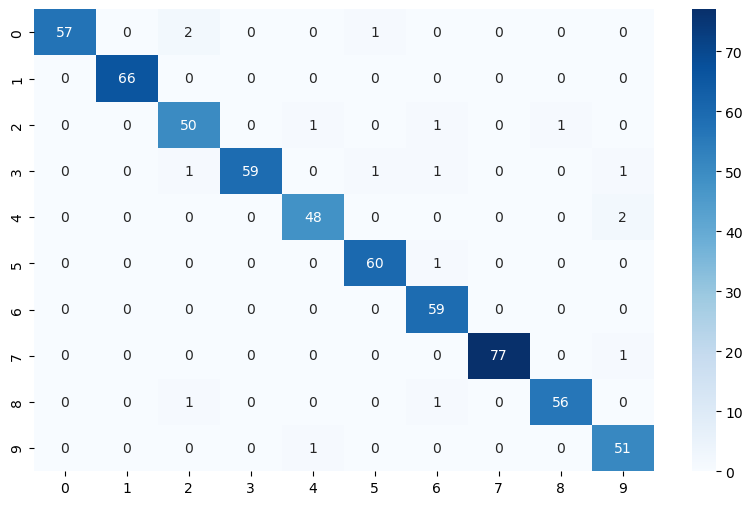

In [87]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

predicted_labels = torch.argmax(torch.tensor(val_predictions), dim=1).numpy()

conf_matrix = confusion_matrix(val_labels, predicted_labels)
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
sns.heatmap(conf_matrix, annot=True, ax=ax,fmt=',', cmap='Blues')
plt.show()

# Faster R-CNN Model

In [61]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

def get_faster_rcnn_model(num_classes):
    # Load a pre-trained ResNet-50 backbone with FPN
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    
    # Define anchor generator for the Region Proposal Network (RPN)
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))
    
    # Define ROI pooler
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'],
                                                     output_size=7,
                                                     sampling_ratio=2)
    
    # Define Faster R-CNN model
    model = FasterRCNN(backbone,
                       num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)
    
    return model

# Example usage:
# Create a Faster R-CNN model for binary classification with 2 classes
num_classes = 2
faster_rcnn_model = get_faster_rcnn_model(num_classes)
faster_rcnn_model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [67]:
import os
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torch.utils.data import DataLoader
from PIL import Image

def get_faster_rcnn_model(num_classes):
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    
    # Get the number of feature maps generated by the backbone
    backbone_out_channels = backbone.fpn.out_channels
    
    # Define anchor generator with appropriate parameters
    anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
    aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
    anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)
    
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=7, sampling_ratio=2)
    model = FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
    
    return model


# Define your custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        label = int(self.images[idx].split('_')[0])  # Extract the label from the file name

        if self.transform:
            image = self.transform(image)

        return image, label

# Define a function to get the Faster R-CNN model
def get_faster_rcnn_model(num_classes):
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=7, sampling_ratio=2)
    model = FasterRCNN(backbone, num_classes=num_classes, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)
    return model

# Apply transformations if needed (e.g., resizing, normalization)
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                            torchvision.transforms.ToTensor()])

# Create an instance of your custom dataset
dataset = CustomDataset(root_dir='Downloads/images/', transform=transform)

# Prepare data loader
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Instantiate Faster R-CNN model
num_classes = 10  # 10 classes for digits 0-9
faster_rcnn_model = get_faster_rcnn_model(num_classes)

# Define loss function
#loss_fn = faster_rcnn_model.roi_heads.box_predictor.loss

# Define optimizer
optimizer = torch.optim.Adam(faster_rcnn_model.parameters(), lr=0.001)

# Define loss function
def custom_loss(predictions, targets):
    # Compute the loss using predictions and targets
    # Here you can use any suitable loss function like smooth L1 loss or others
    # For demonstration, let's use a placeholder loss
    loss = torch.tensor(0.0, requires_grad=True)  # Placeholder loss
    return loss

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images = list(image for image in images)
        targets = [{'boxes': torch.tensor([[0, 0, 10, 10]]), 'labels': torch.tensor([label])} for label in labels]
        
        # Forward pass
        predictions = faster_rcnn_model(images, targets)
        
        # Compute the loss
        loss_dict = custom_loss(predictions, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")


# Save your trained model
torch.save(faster_rcnn_model.state_dict(), 'faster_rcnn_model.pth')


AssertionError: Anchors should be Tuple[Tuple[int]] because each feature map could potentially have different sizes and aspect ratios. There needs to be a match between the number of feature maps passed and the number of sizes / aspect ratios specified.

# AlexNet & VGG16

In [69]:
import pandas as pd
import torch
import time
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from torchvision import transforms, models
from PIL import Image

# Define custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.iloc[idx, 0]
        image = self.data.iloc[idx, 1:].values.astype(float).reshape(28, 28)  # Assuming images are 28x28
        image = Image.fromarray(image.astype('uint8'), 'L')  # Convert to PIL image
        if self.transform:
            image = self.transform(image)
        return image, label

In [70]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize((227, 227)),  # Resize images to 227x227
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

# Load pre-trained AlexNet model

In [73]:
alexnet = models.alexnet(pretrained=True)

C:\Users\dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Fine Tune AlexNet Model

In [74]:
# Freeze the convolutional layers
for param in alexnet.features.parameters():
    param.requires_grad = False

# Modify the classifier
num_features = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_features, 10)  # Assuming 10 classes

# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

# Define loss function and optimizer of AlexNet Model

In [75]:
alexnet_criterion = nn.CrossEntropyLoss()
alexnet_optimizer = optim.Adam(alexnet.parameters(), lr=0.001)  # Change optimizer to Adam

# Train AlexNet Model & print the Metrics

In [76]:
start_time = time.time()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device).float(), labels.to(device)  # Convert input to float
        alexnet_optimizer.zero_grad()
        outputs = alexnet(images)
        loss = alexnet_criterion(outputs, labels)
        loss.backward()
        alexnet_optimizer.step()
        running_loss += loss.item()
        alexnet_f1 = f1_score(true_labels, predictions, average='macro')
        alexnet_accuracy = accuracy_score(true_labels, predictions)
        
        # Print loss after every 100 batches
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}, F1 Score: {alexnet_f1}, Accuracy: {alexnet_accuracy}")
            running_loss = 0.0  # Reset running loss
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, F1 Score: {alexnet_f1}, Accuracy: {alexnet_accuracy}")
    
end_time = time.time()
alexnet_training_time = end_time - start_time
print(f"Total training time: {alexnet_training_time:.2f} seconds")

Epoch [1/10], Loss: 0.7156352445875344, F1 Score: 0.9266479690015382, Accuracy: 0.9283333333333333
Epoch [2/10], Loss: 0.14507868116427408, F1 Score: 0.9266479690015382, Accuracy: 0.9283333333333333
Epoch [3/10], Loss: 0.1382898681944138, F1 Score: 0.9266479690015382, Accuracy: 0.9283333333333333
Epoch [4/10], Loss: 0.11121528634899541, F1 Score: 0.9266479690015382, Accuracy: 0.9283333333333333
Epoch [5/10], Loss: 0.10149792753356068, F1 Score: 0.9266479690015382, Accuracy: 0.9283333333333333
Epoch [6/10], Loss: 0.06291422562208027, F1 Score: 0.9266479690015382, Accuracy: 0.9283333333333333
Epoch [7/10], Loss: 0.09081033997139648, F1 Score: 0.9266479690015382, Accuracy: 0.9283333333333333
Epoch [8/10], Loss: 0.09737932919769694, F1 Score: 0.9266479690015382, Accuracy: 0.9283333333333333
Epoch [9/10], Loss: 0.13356847466447538, F1 Score: 0.9266479690015382, Accuracy: 0.9283333333333333
Epoch [10/10], Loss: 0.06356758293144307, F1 Score: 0.9266479690015382, Accuracy: 0.9283333333333333
T

# Evaluate AlexNet Model

In [77]:
alexnet.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Load pre-trained VGG16 Model

In [78]:
vgg16 = models.vgg16(pretrained=True)

C:\Users\dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dell\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Fine Tune VGG16 Model

In [79]:
# Freeze the convolutional layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# Modify the classifier
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 10)  # Assuming 10 classes

# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

# Define loss function and optimizer for VGG16 Model

In [80]:
vgg16_criterion = nn.CrossEntropyLoss()
vgg16_optimizer = optim.Adam(vgg16.parameters(), lr=0.001)  # Change optimizer to Adam

# Train VGG16 Model

In [81]:
start_time = time.time()

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device).float(), labels.to(device)  # Convert input to float
        vgg16_optimizer.zero_grad()
        outputs = alexnet(images)
        loss = vgg16_criterion(outputs, labels)
        loss.backward()
        vgg16_optimizer.step()
        running_loss += loss.item()
        vgg16_f1 = f1_score(true_labels, predictions, average='macro')
        vgg16_accuracy = accuracy_score(true_labels, predictions)
        
        # Print loss after every 100 batches
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}, F1 Score: {vgg16_f1}, Accuracy: {vgg16_accuracy}")
            running_loss = 0.0  # Reset running loss
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, F1 Score: {vgg16_f1}, Accuracy: {vgg16_accuracy}")
    
end_time = time.time()
vgg16_training_time = end_time - start_time
print(f"Total training time: {vgg16_training_time:.2f} seconds")

Epoch [1/10], Loss: 0.0021690809518005202, F1 Score: 0.9831255032465858, Accuracy: 0.9833333333333333
Epoch [2/10], Loss: 0.002168806195108549, F1 Score: 0.9831255032465858, Accuracy: 0.9833333333333333
Epoch [3/10], Loss: 0.002169081583073612, F1 Score: 0.9831255032465858, Accuracy: 0.9833333333333333
Epoch [4/10], Loss: 0.0021688194349101316, F1 Score: 0.9831255032465858, Accuracy: 0.9833333333333333
Epoch [5/10], Loss: 0.002168914873299113, F1 Score: 0.9831255032465858, Accuracy: 0.9833333333333333
Epoch [6/10], Loss: 0.0022048423716264074, F1 Score: 0.9831255032465858, Accuracy: 0.9833333333333333
Epoch [7/10], Loss: 0.0021697437755631797, F1 Score: 0.9831255032465858, Accuracy: 0.9833333333333333
Epoch [8/10], Loss: 0.0021688398168958215, F1 Score: 0.9831255032465858, Accuracy: 0.9833333333333333
Epoch [9/10], Loss: 0.0021689116437253113, F1 Score: 0.9831255032465858, Accuracy: 0.9833333333333333
Epoch [10/10], Loss: 0.0021701039989591806, F1 Score: 0.9831255032465858, Accuracy: 0

# Evaluate VGG16 Model

In [ ]:
vgg16.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())